# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [107]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [108]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import warnings
from datetime import datetime
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [109]:
warnings.filterwarnings("ignore", category=FutureWarning)
build_new_dataset = {'True': True, 'False': False}.get(input('Build New Dataset? (Bool)'))
if build_new_dataset:
    symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
else:
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6

train_new_model = {'True': True, 'False': False}.get(input('Train New Model? (Bool)'))
if train_new_model:
    hidden_layers = ast.literal_eval(f"({input('Hidden Layers: eg. "100, 100"')})")
    verticle_jobs = 1 #'-1' for max

if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

## Data Preparation

In [110]:
symbols = []
if symbol_list == 'filtered':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = np.random.choice(all_symbols, num_symbols, replace=False).tolist()
    symbols = symbols + pd.read_csv("../data/filtered_tickers.csv")["Ticker"].tolist()

symbols = symbols + pd.read_csv('../data/simple_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['AA', 'AAT', 'ABR', ..., 'BABA', 'WB', 'SYDB.CO'], dtype=object)

#### Download annual financial data

In [111]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv('../data/filtered_tickers.csv')
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Name': ticker.info["displayName"], 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan
            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'
            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]
            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]
            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]
            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            if len(earning_dates) == 5:
                earning_dates.remove(earning_dates[4])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f"{symbol} had {len(earning_dates)} earning dates, not 5")
                continue
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Name': ticker.info["displayName"], 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'
                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]
                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]
                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) != 4:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because the length of the df was not 4, it was {len(ticker_df)}')
                continue

            if ticker_df.isna().sum().sum() < round(352 * minimum_feature_threshold):
                if symbol not in filtered_pd['Ticker'].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{'Ticker': symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(['Ticker', 'Name', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                    if debugging:
                        print(f'Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(352 * minimum_feature_threshold)}')
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd['Ticker'].tolist():
                filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because an exception was raised')
                    print(error)
            continue
    filtered_pd.to_csv('../data/filtered_tickers.csv', index=False)
    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [112]:
if debugging:
    display(df)

,Ticker,Name,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Net Income Extraordinary,Restricted Common Stock,Dividends Paid Direct,Depletion Income Statement,Net Income From Tax Loss Carryforward
0,AA,Alcoa,2025-03-31,NaN,NaN,NaN,Basic Materials,Aluminum,-1.800000e+07,-2.166667e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AA,Alcoa,2023-12-31,-0.018451,0.130405,0.123098,Basic Materials,Aluminum,-4.400000e+08,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AA,Alcoa,2022-12-31,-0.062309,-0.250328,-0.243344,Basic Materials,Aluminum,3.420000e+08,-5.000000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AA,Alcoa,2021-12-31,0.522660,-0.246283,-0.231174,Basic Materials,Aluminum,5.300000e+08,-1.500000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAT,American Assets Trust,2025-03-31,NaN,NaN,NaN,Real Estate,REIT - Diversified,2.042400e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6275,IQ,iQIYI,2021-12-31,0.048246,-0.041667,0.162281,Communication Services,Entertainment,-6.352582e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6276,UBER,Uber,2025-03-31,NaN,NaN,NaN,Technology,Software - Application,2.250000e+09,-1.785000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6277,UBER,Uber,2023-12-31,0.219354,0.114032,-0.025024,Technology,Software - Application,3.362000e+09,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6278,UBER,Uber,2022-12-31,0.281844,0.745653,1.489689,Technology,Software - Application,3.900000e+08,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [113]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Name', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [114]:
pred_data = pd.DataFrame()
train_data = pd.DataFrame()
for i in range(int(len(df) / 4)):
    pred_data = pd.concat([pred_data, df.iloc[[i*4]]]) 
    train_data = pd.concat([train_data, df.iloc[[1+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*4]]])
if debugging:
    print('Prediction Data:')
    display(pred_data)
    print('Train and Test Data:')
    display(train_data)

Prediction Data:


,Ticker,Name,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Net Income Extraordinary,Restricted Common Stock,Dividends Paid Direct,Depletion Income Statement,Net Income From Tax Loss Carryforward
0,AA,Alcoa,2025-03-31,NaN,NaN,NaN,0,5,-0.005053,0.054917,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
4,AAT,American Assets Trust,2025-03-31,NaN,NaN,NaN,8,95,-0.004987,0.000000,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
8,ABR,Arbor Realty Trust,2025-03-31,NaN,NaN,NaN,8,99,-0.004764,0.066532,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
12,ACI,Albertsons Companies,2025-02-28,NaN,NaN,NaN,3,54,-0.004552,0.071215,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
16,ACRE,Ares Commercial Real Estate,2025-03-31,NaN,NaN,NaN,8,99,-0.005009,0.071100,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6260,PDD,PDD,2025-03-31,NaN,NaN,NaN,2,69,0.021638,0.000000,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
6264,BIDU,Baidu,2025-03-31,NaN,NaN,NaN,1,68,-0.015333,-0.286585,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
6268,NTES,NetEase,2025-03-31,NaN,NaN,NaN,1,41,0.014485,0.048378,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
6272,IQ,iQIYI,2025-03-31,NaN,NaN,NaN,1,44,-0.004440,0.000000,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0


Train and Test Data:


,Ticker,Name,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Net Income Extraordinary,Restricted Common Stock,Dividends Paid Direct,Depletion Income Statement,Net Income From Tax Loss Carryforward
1,AA,Alcoa,2023-12-31,-0.018451,0.130405,0.123098,0,5,-0.005778,0.071215,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
2,AA,Alcoa,2022-12-31,-0.062309,-0.250328,-0.243344,0,5,-0.004435,0.033605,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
3,AA,Alcoa,2021-12-31,0.522660,-0.246283,-0.231174,0,5,-0.004112,0.059932,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
5,AAT,American Assets Trust,2023-12-31,-0.031142,-0.031311,0.220023,8,95,-0.004841,0.000000,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
6,AAT,American Assets Trust,2022-12-31,-0.288542,-0.252711,-0.095800,8,95,-0.004910,0.000000,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6274,IQ,iQIYI,2022-12-31,0.373585,0.007547,-0.079245,1,44,-0.005607,0.000000,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
6275,IQ,iQIYI,2021-12-31,0.048246,-0.041667,0.162281,1,44,-0.015937,0.000000,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
6277,UBER,Uber,2023-12-31,0.219354,0.114032,-0.025024,9,118,0.000754,0.071215,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
6278,UBER,Uber,2022-12-31,0.281844,0.745653,1.489689,9,118,-0.004352,0.071215,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0


### Labeling

In [115]:
ignore_columns = ["Ticker", "Name", "Date", '3M Future Change', '6M Future Change', '1Y Future Change']
X_pred = pred_data.drop(ignore_columns, axis=1)
X_train = train_data.drop(ignore_columns, axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

if debugging:
    display(X_train)
    display(y_train)
    display(X_test)
    display(y_test)

,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,Effect Of Exchange Rate Changes,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Net Income Extraordinary,Restricted Common Stock,Dividends Paid Direct,Depletion Income Statement,Net Income From Tax Loss Carryforward
1983,7,74,-0.005025,0.071215,0.039824,-0.038518,0.048428,-0.054325,-0.056211,-9.615157e-18,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
5649,1,68,-0.005014,0.000000,0.040211,-0.038788,0.049204,-0.054436,-0.056219,-2.752127e-02,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
919,7,1,0.000792,-0.066289,0.038194,-0.037501,0.046580,-0.053239,-0.053856,-9.615157e-18,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
6074,9,115,-0.004878,0.000000,0.040211,-0.038788,0.049201,-0.054336,-0.056135,-2.752935e-02,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
1358,8,100,-0.004588,0.053372,0.039952,-0.038347,0.048921,-0.054237,-0.056071,-9.615157e-18,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5489,7,104,-0.005036,0.071215,0.040147,-0.038733,0.049237,-0.054423,-0.056205,-9.615157e-18,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
1182,8,98,-0.004479,0.000000,0.039761,-0.038248,0.049175,-0.054453,-0.056233,-9.615157e-18,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
1987,5,32,-0.004298,0.066844,0.038724,-0.038071,0.049097,-0.053549,-0.055429,-2.753003e-02,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
5055,1,0,-0.005196,0.071065,0.040210,-0.038770,0.049259,-0.054377,-0.056085,-9.615157e-18,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0


,3M Future Change,6M Future Change,1Y Future Change
1983,0.413641,-0.082384,0.041764
5649,0.006536,-0.055556,-0.616340
919,0.169854,0.091842,0.216882
6074,0.137244,0.382131,0.670075
1358,-0.291045,-0.538280,0.018629
...,...,...,...
5489,0.441947,0.370787,2.576779
1182,0.125272,0.190305,0.276880
1987,-0.115945,-0.111890,-0.060388
5055,-0.096014,-0.650861,-0.916810


,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,Effect Of Exchange Rate Changes,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Net Income Extraordinary,Restricted Common Stock,Dividends Paid Direct,Depletion Income Statement,Net Income From Tax Loss Carryforward
5150,5,13,-0.004973,0.071026,0.040199,-0.038774,0.049269,-0.054429,-0.056062,-9.615157e-18,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
1090,7,121,-0.004821,0.061449,0.039923,-0.038485,0.049250,-0.054332,-0.056110,-9.615157e-18,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
198,9,42,-0.005215,-0.007728,0.040070,-0.038334,0.049036,-0.054319,-0.056049,-2.817683e-02,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
2078,2,124,-0.004710,0.049702,0.040186,-0.038788,0.049109,-0.054147,-0.055784,-2.757922e-02,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
531,0,19,-0.000856,0.003817,0.039734,-0.038788,0.044552,-0.050072,-0.049729,-3.052323e-02,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2175,9,118,-0.005128,0.070815,0.040136,-0.038626,0.049251,-0.054311,-0.056084,-2.752606e-02,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
2419,5,32,-0.004710,0.066142,0.039349,-0.037876,0.049255,-0.054340,-0.056176,-9.615157e-18,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
3161,9,118,-0.004954,0.070697,0.040211,-0.038788,0.049251,-0.054344,-0.056142,-2.752858e-02,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0
5099,9,42,-0.005013,0.000000,0.040204,-0.038787,0.049274,-0.054409,-0.056223,-9.615157e-18,...,-8.781422e-15,3.349484e-15,0.0,-3.475522e-15,1.813409e-15,0.0,0.0,0.0,0.0,0.0


,3M Future Change,6M Future Change,1Y Future Change
5150,-0.112798,-0.100059,0.024227
1090,0.056350,0.137247,0.335966
198,0.194128,0.369704,0.169073
2078,-0.012297,0.028107,0.236276
531,-0.220000,-0.322101,-0.224030
...,...,...,...
2175,-0.207125,-0.278378,-0.505969
2419,-0.150983,-0.306744,-0.496188
3161,0.209233,0.304178,-0.102540
5099,-0.159690,-0.489922,-0.821705


## Model Training

In [116]:
if train_new_model:
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        learning_rate="adaptive",
        early_stopping=True,
        verbose=True,
        n_iter_no_change=20
    )
    model.fit(X_train, y_train)

Iteration 1, loss = 500.54685252
Validation score: -0.041698
Iteration 2, loss = 0.11635217
Validation score: -0.034558
Iteration 3, loss = 0.10484034
Validation score: -0.002520
Iteration 4, loss = 0.10007802
Validation score: -0.001411
Iteration 5, loss = 0.09991534
Validation score: -0.009037
Iteration 6, loss = 0.09884900
Validation score: -0.014760
Iteration 7, loss = 0.10035984
Validation score: -0.011494
Iteration 8, loss = 0.09984871
Validation score: -0.006554
Iteration 9, loss = 0.09853992
Validation score: -0.007747
Iteration 10, loss = 0.09943335
Validation score: -0.001076
Iteration 11, loss = 0.09887375
Validation score: -0.002749
Iteration 12, loss = 0.09842034
Validation score: -0.000585
Iteration 13, loss = 0.09825940
Validation score: 0.000192
Iteration 14, loss = 0.09831251
Validation score: -0.021882
Iteration 15, loss = 0.09925479
Validation score: -0.017044
Iteration 16, loss = 0.09846069
Validation score: -0.003059
Iteration 17, loss = 0.09860556
Validation score

## Testing and benchmarking

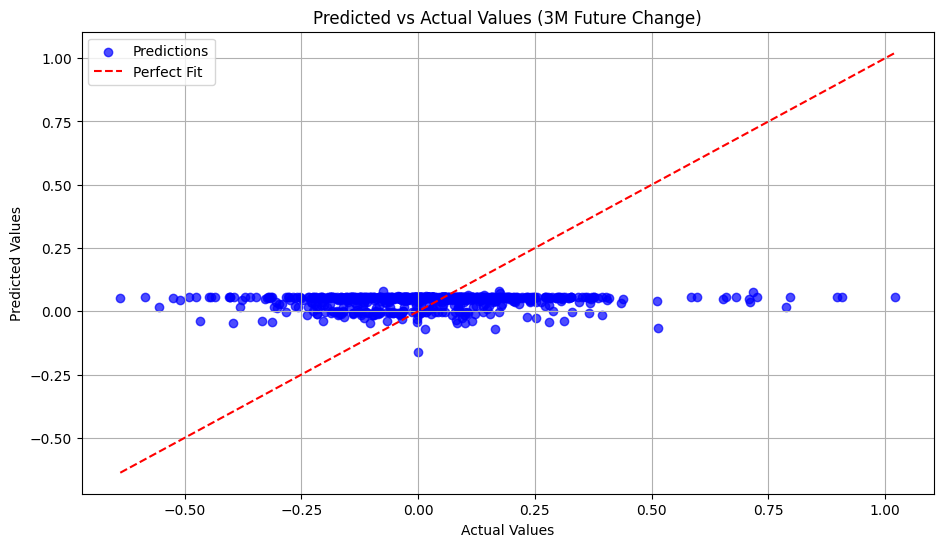

3M Future Change - R²: 0.0010
3M Future Change - MSE: 0.0412
3M Future Change - MAE: 0.1486


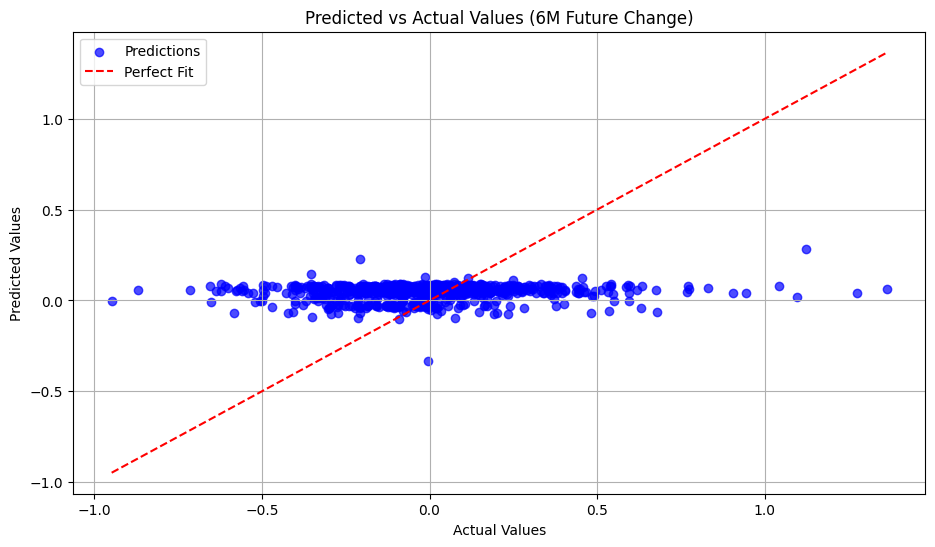

6M Future Change - R²: -0.0397
6M Future Change - MSE: 0.0803
6M Future Change - MAE: 0.2139


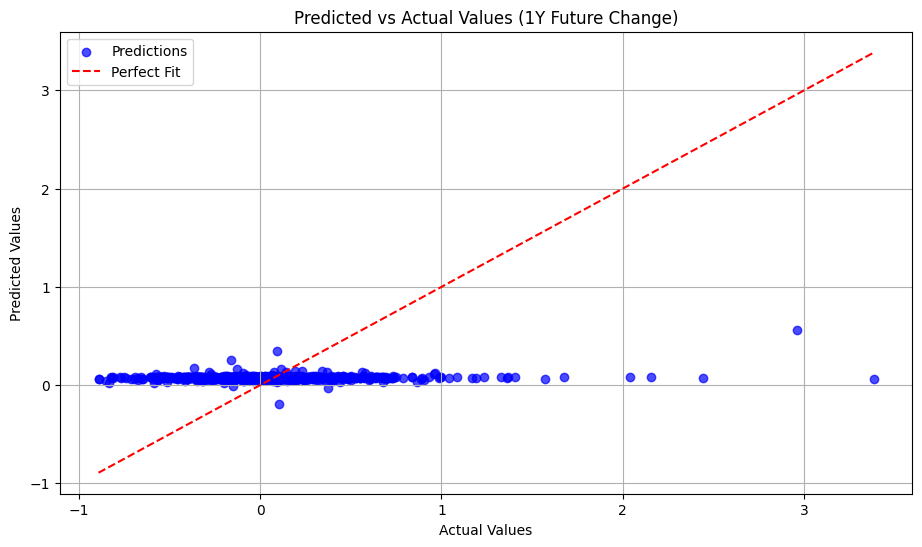

1Y Future Change - R²: 0.0142
1Y Future Change - MSE: 0.1877
1Y Future Change - MAE: 0.3064

Overall Scores:
Mean - R²: -0.0082
Mean - MSE: 0.1031
Mean - MAE: 0.2230


In [117]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
        y_test_actual = y_test[target]
        y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [118]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        'hidden_layer_sizes': [model.hidden_layer_sizes],
        'max_iter': model.max_iter,
        'n_iter_no_change': model.n_iter_no_change,
        'learning_rate': model.learning_rate,
        'learning_rate_init': model.learning_rate_init,
        'batch_size': model.batch_size,
        'tol': model.tol,
        'alpha': model.alpha,
        'shuffle': model.shuffle,
    })
    test_results.to_csv('../data/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../models/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

Old best R²: -0.0197202101788767
New best R²: -0.00816777739572346
Saving new best model...


## Predictions on latest data

In [119]:
best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: -0.0081677773957234


In [120]:
df_raw = pd.read_csv('../data/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_1y) / 3
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

,Ticker,Name,mean (%),3m (%),6m (%),1y (%)
0,AA,Alcoa,-3.409956,-5.374477,-8.130804,3.275411
1,AAT,American Assets Trust,6.763109,5.485524,6.733401,8.070403
2,ABR,Arbor Realty Trust,6.897894,5.505712,7.008386,8.179585
3,ACI,Albertsons Companies,5.869118,5.216651,4.771614,7.619088
4,ACRE,Ares Commercial Real Estate,6.900266,5.507250,7.010586,8.182963
...,...,...,...,...,...,...
1565,PDD,PDD,6.360725,5.244794,5.874369,7.963012
1566,BIDU,Baidu,6.342935,5.444908,5.811676,7.772220
1567,NTES,NetEase,5.918443,4.782889,4.805859,8.166583
1568,IQ,iQIYI,6.168962,5.951924,5.015802,7.539160


In [121]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"The author was stupid and forgot to cover this obvious, famous stock. Try another.", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "")

In [122]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'MATAS.CO'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://9b1b3004861fbdcd1d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
